#  Dataset Description
##  Total Samples:
### 300 sentences

##  Task:
### Binary classification — Determine whether a sentence is written by a human or AI.

##  Labels:
### 0 → Human-written

### 1 → AI-generated

## Each class has 150 samples, so the dataset is balanced.

##  Subcategories (within each class):
### Each of the 150 samples is evenly divided into 3 topics:

### 50 Business

### 50 Sports

### 50 Science

-----------------------------------

# Import Libraries

In [3]:
import pandas as pd
import string
import nltk
import numpy as np
from nltk.corpus import words, stopwords, wordnet
import re
from sklearn.base import BaseEstimator, TransformerMixin
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from transformers import BertTokenizer, BertModel
from sklearn.pipeline import Pipeline
import torch
import time
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

nltk.download('averaged_perceptron_tagger_eng')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Read Data

In [ ]:
df = pd.read_csv('Dataset/data_ML.csv').drop('Unnamed: 0', axis=1)

In [5]:
df.head()

,type,content,generated
0,science,The other common type of ink in elections is i...,0.0
1,science,Laws on net cafe opening hours and who can use...,0.0
2,science,Microsoft is investigating a trojan program th...,0.0
3,science,"He said one laptop per child could be "" very i...",0.0
4,science,"""We are hoping to understand the creative indu...",0.0


# Clean/Preprocess the Data
## Convert to Lower
## expand contractions
## Remove Punctuation
## Remove Stopword
## Remove SpecialChar
## Lemmatizing
## Vectorizing Using BERT

In [ ]:
# Convert abb to the original words
class ContractionExpander(BaseEstimator, TransformerMixin):
    def __init__(self, contractions_dict):
        self.contractions = contractions_dict

    def transform(self, X, y=None):
        return X.apply(self.expand_text)

    def fit(self, X, y=None):
        return self

    def expand_text(self, text):
        if isinstance(text, str):
            for key, val in self.contractions.items():
                text = text.replace(key, val)
        return text

In [7]:
# Convert the string characters to lowercase
class ConvertLower(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
        return X.apply(lambda text: text.lower())

    def fit(self, X, y=None):
        return self

In [8]:
# Remove Punctuation characters (.,)
class PunctuationRemover(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
        return X.apply(lambda text: text.translate(str.maketrans('', '', string.punctuation)))

    def fit(self, X, y=None):
        return self

In [ ]:
# Remove Stopwords (the, a, an, etc)
class StopwordRemover(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stopwords = set(stopwords.words('english'))

    def transform(self, X, y=None):
        return X.apply(lambda text: " ".join([word for word in text.split() if word not in self.stopwords]))

    def fit(self, X, y=None):
        return self

In [ ]:
# Remove all special charaters
class SpecialCharRemover(BaseEstimator, TransformerMixin):
    def transform(self, X, y=None):
        return X.apply(self.clean_text)

    def fit(self, X, y=None):
        return self

    def clean_text(self, text):
        text = re.sub('[^a-zA-Z0-9]', ' ', text)
        text = re.sub('\s+', ' ', text)
        return text.strip()

In [ ]:
# Lemmitizing Words to give me the root of the words
class Lemmatizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.wordnet_map = {"N": wordnet.NOUN,
                            "V": wordnet.VERB, "J": wordnet.ADJ, "R": wordnet.ADV}

    def transform(self, X, y=None):
        return X.apply(self.lemmatize)

    def fit(self, X, y=None):
        return self

    def lemmatize(self, text):
        pos_text = pos_tag(text.split())
        return " ".join([self.lemmatizer.lemmatize(word, self.wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_text])

In [ ]:
# Tokenize and Vectorize Using BERT Model
class BERTVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.model = BertModel.from_pretrained('bert-base-uncased')

    def transform(self, X, y=None):
        embeddings = []
        for text in X:
            inputs = self.tokenizer(
                text, return_tensors='pt', truncation=True, padding=True, max_length=512)
            with torch.no_grad():
                outputs = self.model(**inputs)
            cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze(
            ).cpu().numpy()
            embeddings.append(cls_embedding)
        return np.vstack(embeddings)

    def fit(self, X, y=None):
        return self

In [ ]:
# Dictionary of all words and thier constructions
contractions = {
    "ain't": "am not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'd've": "he would have",
    "he'll": "he will",
    "he'll've": "he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how does",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so is",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    " u ": " you ",
    " ur ": " your ",
    " n ": " and ",
    "won't": "would not",
    'dis': 'this',
    'bak': 'back',
    'brng': 'bring',
    "won't": "would not",
    'dis': 'this',
    "bak": "back",
    "brng": 'bring'
}

In [ ]:
# pipeline combine all preprocessing and clean steps
preprocessing_pipeline = Pipeline([
    ('convert_lower', ConvertLower()),
    ('expand_contractions', ContractionExpander(contractions)),
    ('remove_punctuation', PunctuationRemover()),
    ('remove_stopwords', StopwordRemover()),
    ('remove_special_chars', SpecialCharRemover()),
    ('lemmatize', Lemmatizer()),
    ('bert_vectorize', BERTVectorizer())
])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [15]:
# Choose content as feature represented in X
# choose generated as target represented in y
X = df['content']
y = df['generated']

In [16]:
# Apply pipeline to convert content column to be represented with vectors
X = preprocessing_pipeline.fit_transform(X)

In [17]:
# Create Dataframe contain data after vectorization
df_vectorize = pd.DataFrame(X)
df_vectorize['generated'] = y
df_vectorize['type'] = df['type']
df_vectorize.shape

(300, 770)

In [ ]:
df_vectorize.to_csv('Requirements/df_vectorize.csv')

## Split Data

# Save the dataset
## df_vectorize.csv (Full dataset with vectors)
## train.csv and test.csv (80/20 split)



In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [20]:
# Create train file contain X_train and y_train
train = pd.DataFrame(X_train)

In [21]:
train['generated'] = y_train

In [22]:
# Create test file contain X_test and y_test
test = pd.DataFrame(X_test)
test['generated'] = y_test

In [ ]:
train.to_csv('Requirements/train.csv')
test.to_csv('Requirements/test.csv')

# Supervised Learning Classification Task
## Logistic Regression
## Random Forest Classifier

In [24]:
# Logistic Regression Model to Classify Data
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [25]:
y_pred_lr = lr.predict(X_test)

In [26]:
print(accuracy_score(y_test, y_pred_lr))

0.9833333333333333


In [ ]:
# Random Forest Model to Classify Data
rf = RandomForestClassifier(n_estimators=100, max_depth=10)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10)

In [28]:
y_pred_rf = rf.predict(X_test)
y_train_rf = rf.predict(X_train)

In [29]:
print(accuracy_score(y_train, y_train_rf))
print(accuracy_score(y_test, y_pred_rf))

1.0
0.95


# Unsupervised Learning Task
## Use K-means clustering on human-written samples to find subgroups or “writing styles” within the dataset.
### Cluster based on writing patterns.
### Visualize clusters using PCA

In [ ]:
# Make Dataframe for Human only
df_human = df_vectorize[df_vectorize['generated'] == 0]

In [ ]:
X_human = df_human.drop(columns=['generated', 'type'], axis=1)

In [32]:
# Create Model with 3 Clusters (Sport, Science, Business)
kmeans = KMeans(n_clusters=3, random_state=42)

In [33]:
X_human = np.array(X_human)

In [34]:
y_kmean_pred = kmeans.fit_predict(X_human)

In [35]:
# Extract the most 2 feature represent my data to visualize
pca = PCA(n_components=2)
X_human_pca = pca.fit_transform(X_human)

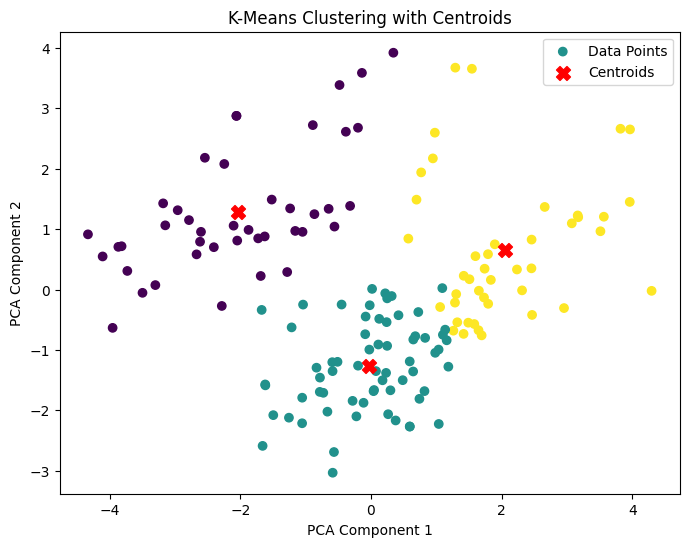

In [36]:
# Visualize Clusters
plt.figure(figsize=(8, 6))

plt.scatter(X_human_pca[:, 0], X_human_pca[:, 1], c=y_kmean_pred,
            cmap='viridis', label='Data Points')

centroids = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='X',
            s=100, label='Centroids')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('K-Means Clustering with Centroids')
plt.legend()

plt.show()

# Deep Learning Task with FFNN Model
## compute run time with CPU and GPU

In [37]:
# Create FFNN model
model = Sequential([
    Dense(256, activation='relu', input_shape=(768,)),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [38]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Fitting model using CPU
# # CPU Time
# start = time.time()
# fit_model = model.fit(
#     X_train, y_train,
#     epochs=20,
#     batch_size=16,
#     validation_split=0.2,
#     verbose=1
# )
# end = time.time()

# print(f"Training Time for CPU: {end - start:.2f} seconds")

# Training Time for CPU: 11.64 seconds

In [ ]:
# Fitting model using GPU
# GPU Time
start = time.time()
fit_model = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=16,
    validation_split=0.2,
    verbose=1
)
end = time.time()

print(f"Training Time for GPU: {end - start:.2f} seconds")

# Training Time for GPU: 7.13 seconds

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - accuracy: 0.7172 - loss: 0.5281 - val_accuracy: 0.9375 - val_loss: 0.2196
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9712 - loss: 0.1695 - val_accuracy: 0.9583 - val_loss: 0.1255
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9542 - loss: 0.1039 - val_accuracy: 0.9792 - val_loss: 0.0697
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9856 - loss: 0.0715 - val_accuracy: 0.9792 - val_loss: 0.0677
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9839 - loss: 0.0564 - val_accuracy: 1.0000 - val_loss: 0.0445
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9834 - loss: 0.0415 - val_accuracy: 0.9792 - val_loss: 0.0437
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0185 - val_accuracy: 1.0000 - val_loss: 0.0378
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0145 - val_accuracy: 0.9792 - val_loss

In [41]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Validation Accuracy: {accuracy:.2f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - accuracy: 0.9889 - loss: 0.0975
Validation Accuracy: 0.98
